*** Setup the environment. ***

In [1]:
# Setup Environment
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import psutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import torch
import seaborn as sns
import pickle
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch.nn import Linear
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import time

if torch.cuda.is_available():
    print("CUDA GPU is available.")
    device = torch.device('cuda')
else:
    print("CUDA GPU is not available. Using CPU instead.")
    device = torch.device('cpu')
    
print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Total RAM: {(psutil.virtual_memory().total / (1024**3)):.2f} GB")
print(f"Available RAM: {(psutil.virtual_memory().available / (1024**3)):.2f} GB")

CUDA GPU is available.
Current GPU device: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Total RAM: 1006.94 GB
Available RAM: 957.49 GB


## ***Index***

<a name="step0"></a>

### 0. Load Pre-Processed Data
*** Skip if data hasn't been processed. ***

    If one has already completed step 1, load the data here. 
    If not, then complete step 1 first.
    
- 0.1) Load the dataset with spike times in hertz.
- 0.2) Normalize Firing Rates to z scores.
- 0.3) Load the pre-normalized data.

[Go to Step 0](#step0content)

<a name="step1"></a>
### 1. Pull and Process Data
*** Skip if data is pre-processed. ***

    Pull data from the Ecephys repository, process it, then save it to a pickle file.

- 1.1) Download and load necessary packages. 
- 1.2) Create an instance on local computer. 
- 1.3) Choose session an pull data.
- 1.4) Filter invalid spike times.
- 1.5) Bin the data. 
        -1.5.1) Bin the whole experiment.
        -1.5.2) Bin by frame in seconds.
        -1.5.3) Bin by frame in steps.
        -1.5.4) Bin by frame in steps and in parallel. 
- 1.6) Create frame column and save spike times as a dataframe.
- 1.7) Normalize Firing Rates and save normalized firing rates as a dataframe.
    

[Go to Step 1](#step1content)

<a name="step2"></a>
### 2. Visualize the Data

    Here we will run visualizations to explore the information relevant to predicting visual perception with the data.

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number. 
- 2.2) 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped Heat Maps of Unit Resposes by Frames
- 2.6) T-SNE Plot All Neurons
- 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

[Go to Step 2](#step2content)

<a name="step1content"></a>
## 1. Pull and Process Data and Load Pre-Processed Data
[Go to Outline](#outline)

In [2]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache 

In [3]:
## 1. Pull and Process Data 
import time
from pull_and_process_data import master_function

master_function(session_number = 721123822, output_dir="output", timesteps_per_frame=10) #Change saved files to include timesteps 

Updated version 3!
Initializing workflow...
Session data for session number 721123822 has already been downloaded.
Total time elapsed: 0.00 seconds


In [4]:
## 0. Load Pre-Processed Data 
from load_processed_data import master_cleaning_and_saving

master_cleaning_and_saving(session_id=721123822)

Updated!
Data saved to output/spike_trains_with_stimulus_session_721123822.pkl


## 2. Visualize the data

Here we will look at different aspects of the data we are concerned with. 

- 2.0) Pull image data from the Allen SDK Package.
- 2.1) All natural scenes presented by their frame number. 
- 2.2) 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).
- 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 
- 2.4) Sorted correlation matrix between single units.
- 2.5) Grouped Heat Maps of Unit Resposes by Frames
- 2.6) T-SNE Plot All Neurons
- 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

### 2.0) Pull image data from the Allen SDK Package.

*** To set up the environment. *** \
1st, run 2.0.1. \
2nd, run 2.0.2 if one hasn't already calculated the average firing rate per frame. If they haven't been calculated, run 2.0.3 to load them in.

#### 2.0.1) Run Cell to set up environment for visualizations.

In [6]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

'''
 Pick session number
 '''
 
session_number = 721123822

# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

Using existing manifest.json file.


/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1371: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


Session objects
['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'stru

#### 2.0.2) Calulate the firing rates per frame, average firing rate per image, and average firing rate per second.

Calculate the average firing rate per frame. 

In [7]:
# Parameters
timesteps_per_frame = 1  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spikes_per_frame = spike_dataframe.T
spikes_per_frame['frame'] = 'nan'
spikes_per_frame['frame'] = np.array(stimulus_table['frame'])
spikes_per_frame

Processing neurons: 100%|██████████| 1191/1191 [02:19<00:00,  8.56it/s]


950907203  950907205  950907518  950907524  950907209  950907207  \
0             0          6          0          0          0          0   
1             1          1          0          0          0          0   
2             0          2          0          0          0          0   
3             1          2          0          1          0          0   
4             1          3          0          1          0          0   
...         ...        ...        ...        ...        ...        ...   
5945          1          4          0          0          0          0   
5946          2          2          0          1          0          0   
5947          1          4          0          1          0          0   
5948          1          6          0          0          0          0   
5949          1          5          0          0          0          0   

      950907528  950907526  950907214  950907216  ...  950913428  950913495  \
0             0          2          2          0  ...          0          2   
1             0          0          2          0  ...          0          3   
2             0          1          3          0  ...          0          1   
3             0          2          7          0  ...          0          0   
4             0          2          3          2  ...          1          1   
...         ...        ...        ...        ...  ...        ...        ...   
5945          0          0          3          1  ...          0          4   
5946          0          0          2          0  ...          0          2   
5947          0          0          3          2  ...          0          2   
5948          0          0          4          4  ...          0          0   
5949          0          0          2          0  ...          0          1   

      950913484  950913475  950913466  950913839  950913553  950913542  \
0             0          2          0          0          2          0   
1             0          0          0          0          6          0   
2             0          0          0          0          5          0   
3             0          1          1          0          5          2   
4             1          1          0          0          1          0   
...         ...        ...        ...        ...        ...        ...   
5945          0          0          3          0          3          0   
5946          0          0          0          0          4          0   
5947          0          1          0          0          6          0   
5948          1          1          0          0          2          0   
5949          0          2          0          0          9          0   

      950913529  frame  
0             0   92.0  
1             0  114.0  
2             0  114.0  
3             0    0.0  
4             0   37.0  
...         ...    ...  
5945          0   15.0  
5946          0   46.0  
5947          0   86.0  
5948          1  110.0  
5949          0   17.0  

[5950 rows x 1192 columns]

Calculate spikes per image by taking the average of the spikes_per_frame calculation.

In [26]:
spikes_per_image = spikes_per_frame.groupby('frame').mean().iloc[1:,1:]
spikes_per_image.reset_index(inplace=True)
spikes_per_image

frame  950907205  950907518  950907524  950907209  950907207  950907528  \
0      0.0       3.66       0.04       0.46       0.02        0.0        0.0   
1      1.0       3.70       0.02       0.32       0.00        0.0        0.0   
2      2.0       3.38       0.00       0.42       0.00        0.0        0.0   
3      3.0       3.74       0.02       0.46       0.02        0.0        0.0   
4      4.0       3.68       0.00       0.42       0.00        0.0        0.0   
..     ...        ...        ...        ...        ...        ...        ...   
113  113.0       3.48       0.00       0.56       0.02        0.0        0.0   
114  114.0       3.32       0.02       0.30       0.00        0.0        0.0   
115  115.0       3.56       0.02       0.40       0.02        0.0        0.0   
116  116.0       3.58       0.02       0.48       0.00        0.0        0.0   
117  117.0       3.68       0.02       0.46       0.00        0.0        0.0   

     950907526  950907214  950907216  ...  950913437  950913428  950913495  \
0         0.16       2.74       2.34  ...       0.94       0.20       1.40   
1         0.12       2.70       1.78  ...       0.72       0.40       2.74   
2         0.08       2.82       2.26  ...       0.68       3.94       3.42   
3         0.14       2.64       1.78  ...       1.16       0.60       2.48   
4         0.12       2.82       2.12  ...       0.76       0.14       0.56   
..         ...        ...        ...  ...        ...        ...        ...   
113       0.16       2.66       1.84  ...       0.82       0.22       3.44   
114       0.08       2.82       2.24  ...       0.34       1.06       2.06   
115       0.10       2.54       1.94  ...       0.32       0.56       1.72   
116       0.14       2.20       2.00  ...       0.96       0.26       0.72   
117       0.14       2.52       1.60  ...       0.34       0.02       0.80   

     950913484  950913475  950913466  950913839  950913553  950913542  \
0         0.54       1.38       0.78       0.18       4.22       3.04   
1         0.46       1.28       0.56       0.08       2.70       2.46   
2         0.92       2.12       1.36       0.12       4.22       1.58   
3         0.50       1.44       1.06       0.06       3.08       1.00   
4         0.34       1.06       0.34       0.04       2.78       1.02   
..         ...        ...        ...        ...        ...        ...   
113       0.28       1.00       0.60       0.02       3.34       1.18   
114       0.26       1.18       0.54       0.00       4.20       0.18   
115       0.24       1.52       0.56       0.00       4.86       0.30   
116       0.62       0.92       0.22       0.06       3.34       2.34   
117       0.18       0.94       0.70       0.02       3.80       0.16   

     950913529  
0         0.18  
1         0.16  
2         0.76  
3         0.46  
4         0.24  
..         ...  
113       0.42  
114       0.20  
115       1.06  
116       0.10  
117       0.04  

[118 rows x 1191 columns]

Estimate the average spikes per second or firing rate in Hertz by multiplying spikes_per_image by 4. Each frame is roughly a quarter second. One can compute the actual average but that is much more computationally intensive(over 7500 times more intesnive). 

In [30]:
firing_rate_hz = spikes_per_image * 4
firing_rate_hz['frame'] = spikes_per_image['frame']
firing_rate_hz

frame  950907205  950907518  950907524  950907209  950907207  950907528  \
0      0.0      14.64       0.16       1.84       0.08        0.0        0.0   
1      1.0      14.80       0.08       1.28       0.00        0.0        0.0   
2      2.0      13.52       0.00       1.68       0.00        0.0        0.0   
3      3.0      14.96       0.08       1.84       0.08        0.0        0.0   
4      4.0      14.72       0.00       1.68       0.00        0.0        0.0   
..     ...        ...        ...        ...        ...        ...        ...   
113  113.0      13.92       0.00       2.24       0.08        0.0        0.0   
114  114.0      13.28       0.08       1.20       0.00        0.0        0.0   
115  115.0      14.24       0.08       1.60       0.08        0.0        0.0   
116  116.0      14.32       0.08       1.92       0.00        0.0        0.0   
117  117.0      14.72       0.08       1.84       0.00        0.0        0.0   

     950907526  950907214  950907216  ...  950913437  950913428  950913495  \
0         0.64      10.96       9.36  ...       3.76       0.80       5.60   
1         0.48      10.80       7.12  ...       2.88       1.60      10.96   
2         0.32      11.28       9.04  ...       2.72      15.76      13.68   
3         0.56      10.56       7.12  ...       4.64       2.40       9.92   
4         0.48      11.28       8.48  ...       3.04       0.56       2.24   
..         ...        ...        ...  ...        ...        ...        ...   
113       0.64      10.64       7.36  ...       3.28       0.88      13.76   
114       0.32      11.28       8.96  ...       1.36       4.24       8.24   
115       0.40      10.16       7.76  ...       1.28       2.24       6.88   
116       0.56       8.80       8.00  ...       3.84       1.04       2.88   
117       0.56      10.08       6.40  ...       1.36       0.08       3.20   

     950913484  950913475  950913466  950913839  950913553  950913542  \
0         2.16       5.52       3.12       0.72      16.88      12.16   
1         1.84       5.12       2.24       0.32      10.80       9.84   
2         3.68       8.48       5.44       0.48      16.88       6.32   
3         2.00       5.76       4.24       0.24      12.32       4.00   
4         1.36       4.24       1.36       0.16      11.12       4.08   
..         ...        ...        ...        ...        ...        ...   
113       1.12       4.00       2.40       0.08      13.36       4.72   
114       1.04       4.72       2.16       0.00      16.80       0.72   
115       0.96       6.08       2.24       0.00      19.44       1.20   
116       2.48       3.68       0.88       0.24      13.36       9.36   
117       0.72       3.76       2.80       0.08      15.20       0.64   

     950913529  
0         0.72  
1         0.64  
2         3.04  
3         1.84  
4         0.96  
..         ...  
113       1.68  
114       0.80  
115       4.24  
116       0.40  
117       0.16  

[118 rows x 1191 columns]

Save them all

In [33]:
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_frame_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_frame, f)
    
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_image_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_image, f)

# Save the dictionary of valid spike times to a pickle file
with open(f'firing_rate_hz_{session_number}.pkl', 'wb') as f:
    pickle.dump(firing_rate_hz, f)

#### 2.0.3) Load the firing rates per frame, average firing rate per image, and average firing rate per second.

In [37]:
spikes_per_frame = 'spikes_per_frame_721123822.pkl'
spikes_per_image = 'spikes_per_image_721123822.pkl'
firing_rate_hz = 'firing_rate_hz_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_frame, 'rb') as f:
    spikes_per_frame = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_image, 'rb') as f:
    spikes_per_image = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(firing_rate_hz, 'rb') as f:
    firing_rate_hz = pickle.load(f)
    
print(np.shape(spikes_per_frame))
print(np.shape(spikes_per_image))
print(np.shape(firing_rate_hz))

(5950, 1192)
(118, 1191)
(118, 1191)


### 2.1) All natural scenes presented by their frame number. 

In this experiment mice were shown 118 different images of natural scenes around 50 times per image. These images are the events we are trying to predict given the firing rate of each unit.

- Below are all of the images shown.

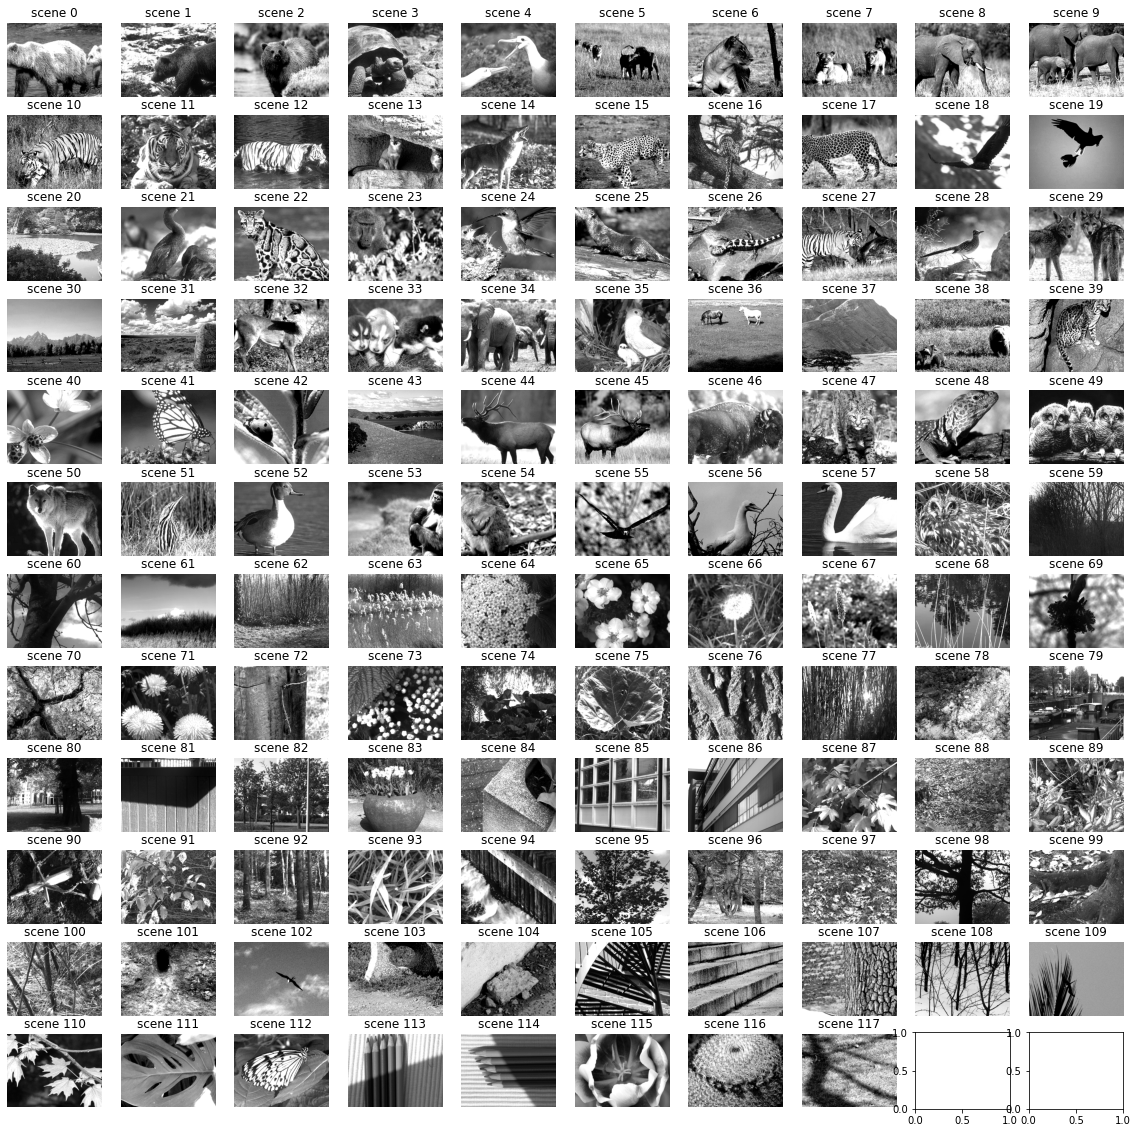

In [7]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name']=='natural_scenes']

# Pull from where images are located.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# Show all scenes.
scene_nums = np.arange(0)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

try:
    fig, axes = plt.subplots(12, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(scenes[i], cmap='gray')
        ax.set_axis_off()
        ax.set_title('scene %d' % i)
except IndexError:
    pass # ignore the IndexError and continue running the code

- Below shows when two different images were shown.

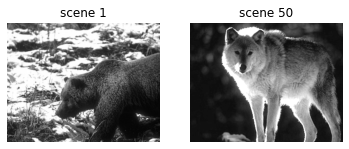

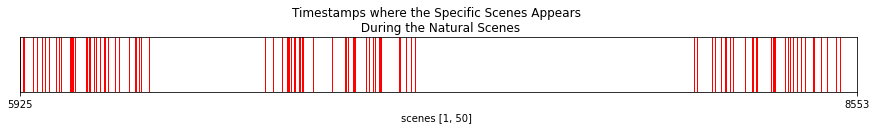

In [7]:
### Choose specific scenes to explore.
scene_nums = [1,50]

### Thank you to http://alleninstitute.github.io/AllenSDK/_static/examples/nb/brain_observatory_stimuli.html for this chunk.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# Define a function that takes two arguments: a dataframe containing information about stimulus trials and a title for the plot.
# The function plots the times each specified stimulus occurs throught the timeframe.
def plot_stimulus_table(natural_scenes, title):
    fstart = natural_scenes.start_time.min()
    fend = natural_scenes.stop_time.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    # Loop over each trial in the dataframe
    for i, trial in natural_scenes.iterrows():    
        # Calculate the start and stop times for the trial.
        x1 = float(trial.start_time - fstart) / (fend - fstart)
        x2 = float(trial.stop_time - fstart) / (fend - fstart)      
        # Add a rectangle to the plot.
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
        
    ax.set_xticks((0,1))
    ax.set_xticklabels((int(np.round(fstart)), int(np.round(fend))))
    ax.set_yticks(())
    ax.set_title("Timestamps where the Specific Scenes Appears \n During the Natural Scenes")
    ax.set_xlabel(title)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# display a couple of the scenes
fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)
    
# build up a mask of trials for which one of a list of scenes is visible
trial_mask = natural_scenes.frame == -2
for scene in scene_nums:
    trial_mask |= (natural_scenes.frame == scene)
natural_scenes = natural_scenes[trial_mask]

# plot the trials
plot_stimulus_table(natural_scenes, "scenes %s " % scene_nums)

### 2.2) Visualize the unique firing pattern of different single units(usually a single neuron).

This unique firing pattern allows one to differenciate between two possible neurons(units) and create a unique spike train for each.

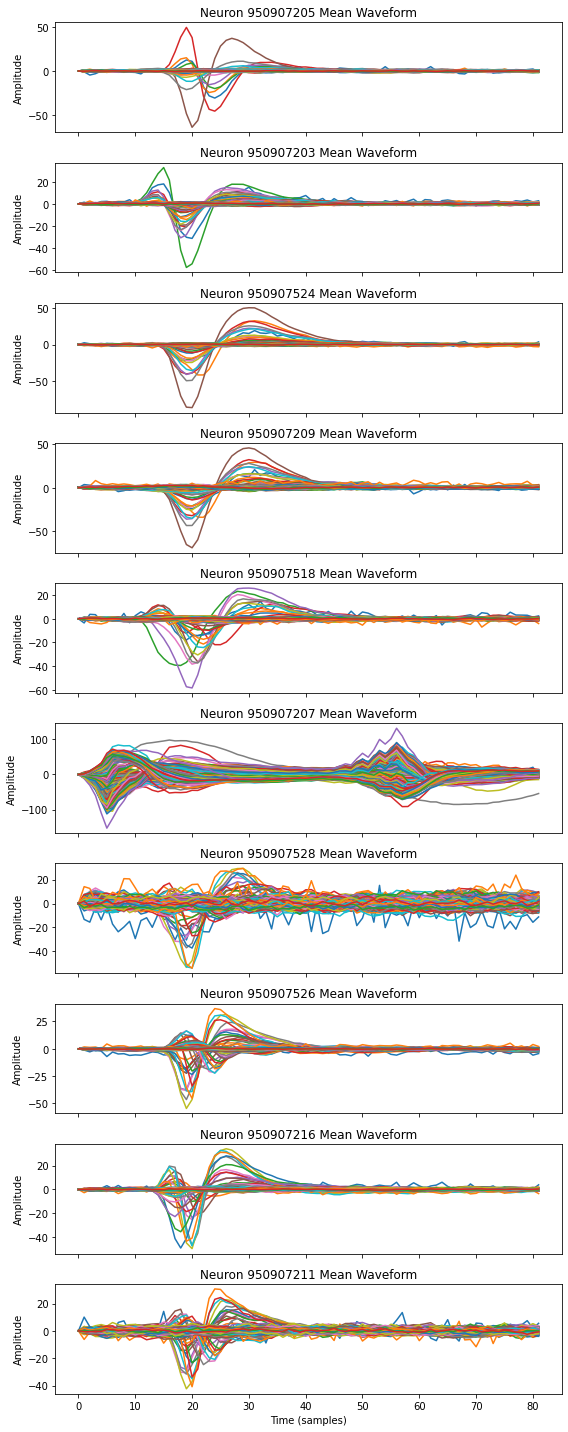

In [8]:
# Get the mean spike waveforms for each neuron
mean_waveforms = session.mean_waveforms

# Number of waveforms to display (you can change this value)
n_waveforms = 10
unit_ids = session.units.index.values

# Plot the mean spike waveforms for the first n_waveforms neurons
fig, axes = plt.subplots(n_waveforms, 1, figsize=(8, 2 * n_waveforms), sharex=True)
for i, (unit_id, ax) in enumerate(zip(unit_ids[:n_waveforms], axes)):
    waveform = mean_waveforms[unit_id]
    ax.plot(waveform.T)
    ax.set_title(f'Neuron {unit_id} Mean Waveform')
    ax.set_ylabel('Amplitude')
    ax.label_outer()

plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


### 2.3) Raster plot of the spike trains for single units over the course of the natural scene testing. 

When the spike trains are created for each unique unit, they produce a 1 for every spike and 0 if they are not spiking at each timestep. The spike trains are plotted below for a few unique units over the natural scene time frame.

*** Add Raster Plot for binned data. ***

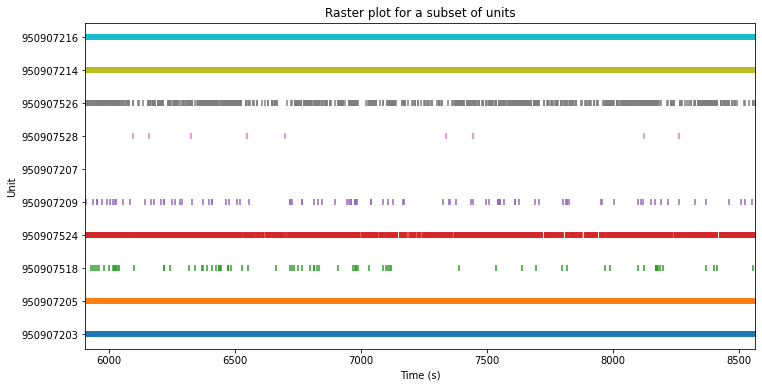

The following is the first 1000 timesteps of the data visualized. 1/30,000th of a second.
[0 1]


950907203  950907205  950907518  950907524  950907209  950907207  \
Time (s)                                                                        
5905.128132          0          0          0          0          0          0   
5905.128165          0          0          0          0          0          0   
5905.128199          0          0          0          0          0          0   
5905.128232          0          0          0          0          0          0   
5905.128265          0          0          0          0          0          0   
...                ...        ...        ...        ...        ...        ...   
5905.161266          0          0          0          0          0          0   
5905.161299          0          0          0          0          0          0   
5905.161332          0          0          0          0          0          0   
5905.161366          0          0          0          0          0          0   
5905.161399          0          0          0          0          0          0   

             950907528  950907526  950907214  950907216  
Time (s)                                                 
5905.128132          0          0          0          0  
5905.128165          0          0          0          0  
5905.128199          0          0          0          0  
5905.128232          0          0          0          0  
5905.128265          0          0          0          0  
...                ...        ...        ...        ...  
5905.161266          0          0          0          0  
5905.161299          0          0          0          0  
5905.161332          0          0          0          0  
5905.161366          0          0          0          0  
5905.161399          0          0          0          0  

[999 rows x 10 columns]

In [9]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name'] == 'natural_scenes']
available_unit_ids = session.spike_times.keys()
all_spike_times = {unit_id: session.spike_times[unit_id] for unit_id in available_unit_ids}
units = cache.get_units()

# Create a function to build a raster plot.
def visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time=0, end_time=10, num_timesteps=30):
    # Select a subset of units to plot
    available_unit_ids = list(all_spike_times.keys())
    subset_unit_ids = available_unit_ids[:num_units_to_visualize]

    # Calculate the time_interval (in seconds) from the first unit's sampling rate
    time_interval = 1 / units.iloc[0]['sampling_rate']

    # Create the raster plot
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, unit_id in enumerate(subset_unit_ids):
        spike_times = all_spike_times[unit_id]

        # Filter the spike times based on start_time and end_time
        filtered_spike_times = [t for t in spike_times if start_time <= t <= end_time]

        ax.scatter(filtered_spike_times, [i] * len(filtered_spike_times), marker='|')

    ax.set_xlim([start_time, end_time])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Unit')
    ax.set_yticks(range(len(subset_unit_ids)))
    ax.set_yticklabels(subset_unit_ids)
    ax.set_title('Raster plot for a subset of units')

    plt.show()

    # Create an array of time bins
    time_bins = np.arange(start_time, start_time + num_timesteps, time_interval)

    # Only consider the first 'num_timesteps' time bins
    time_bins = time_bins[:num_timesteps]

    # Initialize an empty DataFrame with the time bins as the index
    spike_counts_df = pd.DataFrame(index=time_bins[:-1])

    # Iterate through the units and count the spikes in each time bin
    for unit_id in subset_unit_ids:
        spike_times = all_spike_times[unit_id]
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        spike_counts_df[unit_id] = spike_counts

    # Rename the index
    spike_counts_df.index.name = 'Time (s)'

    return spike_counts_df

# Example usage:
num_units_to_visualize = 10
start_time = natural_scenes.start_time.min()
end_time = natural_scenes.stop_time.max()
num_timesteps = 1000

spike_counts_df = visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time, end_time, num_timesteps)
print('The following is the first 1000 timesteps of the data visualized. 1/30,000th of a second.')
print(np.unique(spike_counts_df))
spike_counts_df

### 2.4) Sorted correlation matrix between single units.

Below is a sorted correlation matrix between units based on their firing rates. A clustering method called Agglomerative hierarchical cluster was group the correlation matrix.  

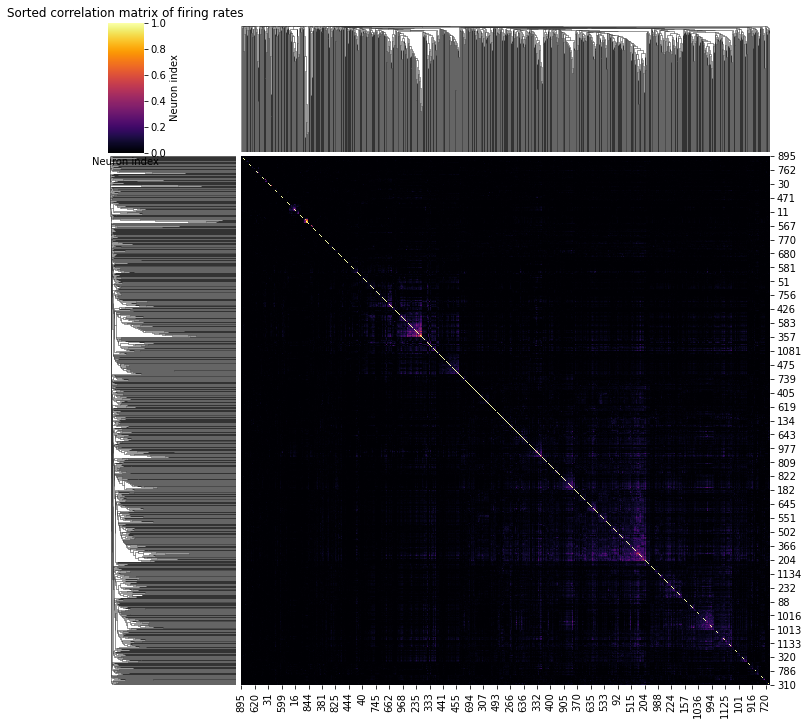

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average')  # The linkage function performs the cluster.

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=0, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

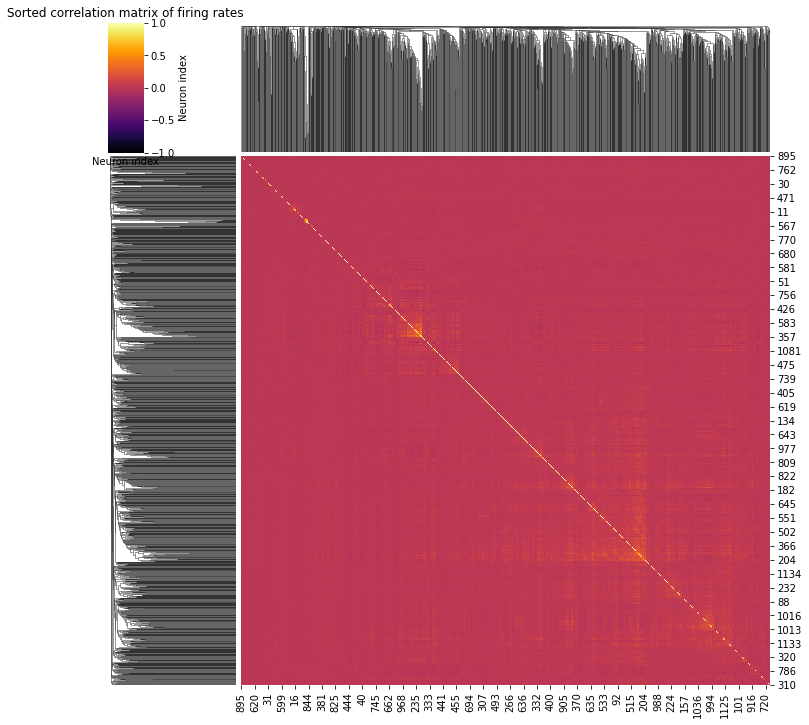

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average') 

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=-1, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

### 2.x) Show Correlation matrices between time steps.

### 2. 5) Grouped heat maps of unit responses by frames.

/tmp/ipykernel_1816090/1663547482.py:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corrwith(df['frame'], method='spearman')


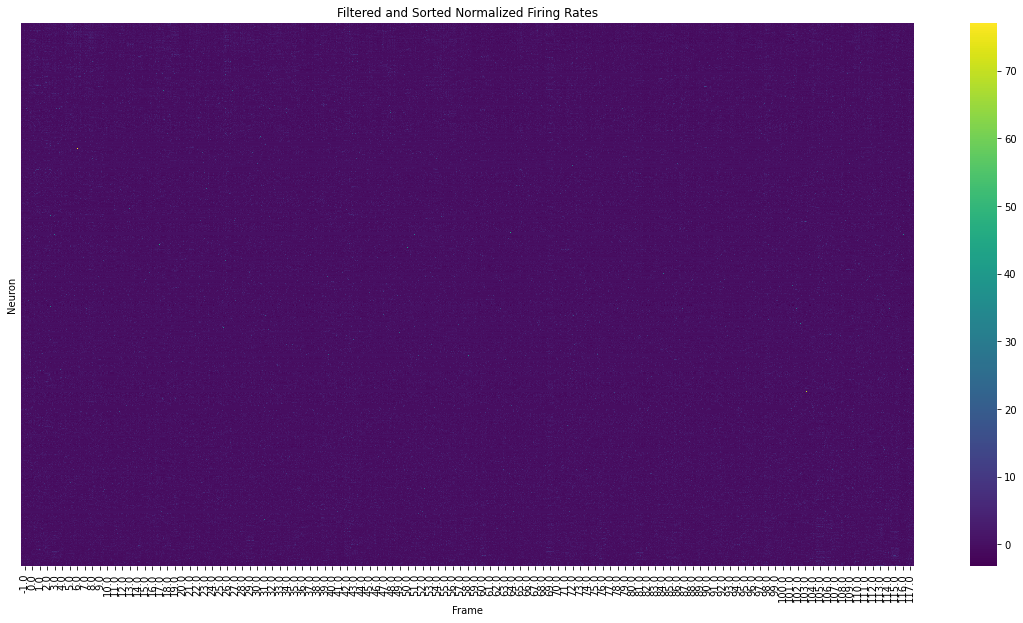

In [15]:
def plot_filtered_normalized_firing_rates(df, num_frames):
    # Calculate the correlation between the firing rates and frames
    correlation_matrix = df.corrwith(df['frame'], method='spearman')

    # Sort neurons by their correlation with the 'frame' column
    sorted_neurons = correlation_matrix[df.columns[1:]].sort_values().index.tolist()

    # Filter the DataFrame based on the desired number of frames
    filtered_df = df.head(num_frames)

    # Sort neurons by their correlation with the 'frame' column
    sorted_filtered_df = filtered_df[['frame'] + sorted_neurons]

    # Sort the DataFrame by the 'frame' column
    sorted_filtered_df.sort_values(by='frame', inplace=True)

    # Set the 'frame' column as the index of the DataFrame
    sorted_filtered_df.set_index('frame', inplace=True)

    # Create a heatmap for the filtered and sorted DataFrame
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(sorted_filtered_df.T, cmap='viridis', yticklabels=False)

    # Get unique frame values
    unique_frames = sorted_filtered_df.index.unique()

    # Set x-ticks at the middle of each frame group
    ax.set_xticks([np.where(sorted_filtered_df.index == frame)[0].mean() for frame in unique_frames])

    # Set x-tick labels to be the frame numbers
    ax.set_xticklabels(unique_frames)

    plt.xlabel('Frame')
    plt.ylabel('Neuron')
    plt.title(f'Filtered and Sorted Normalized Firing Rates')
    plt.show()

# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(firing_rates_per_frame, num_frames=None)

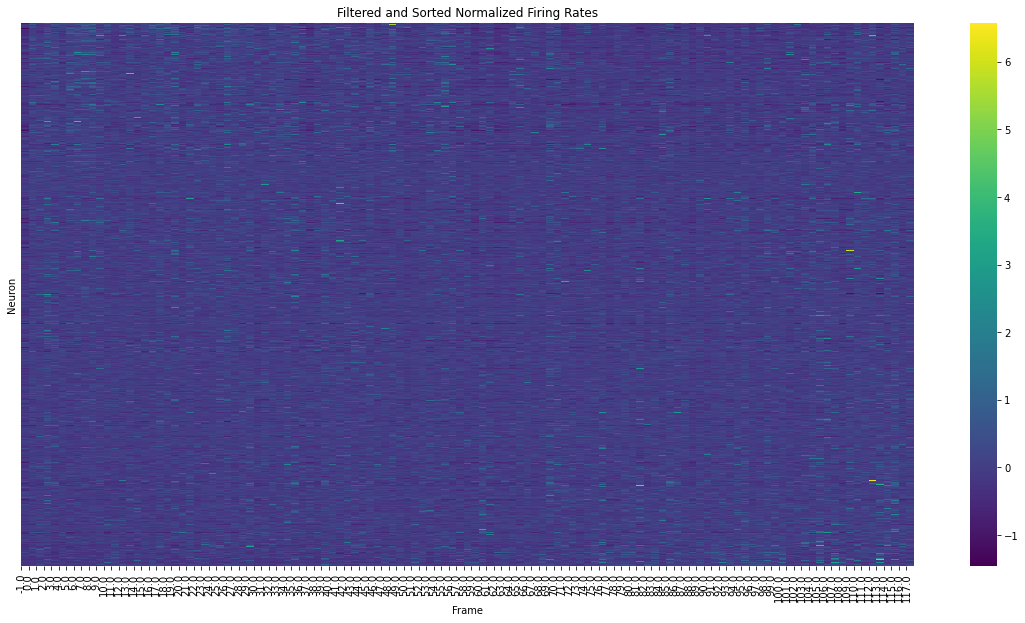

In [17]:
# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(average_firing_rate, num_frames=None)

/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


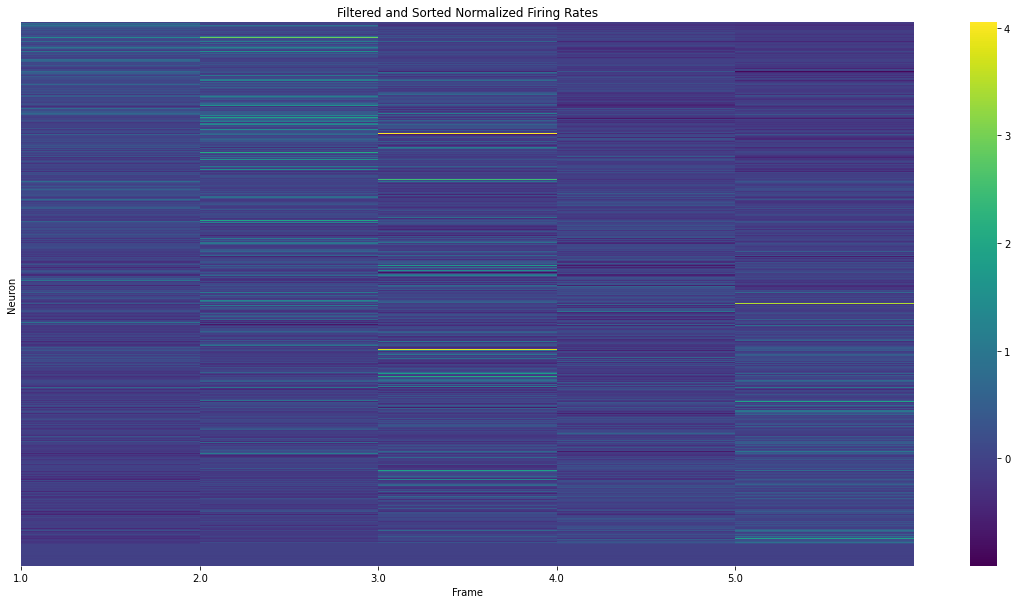

In [18]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,2,3,4,5]
select_images = average_firing_rate[average_firing_rate['frame'].isin(frames_to_select)]
select_images

plot_filtered_normalized_firing_rates(select_images, num_frames=None)

### 2.6) T-SNE plot all neurons.

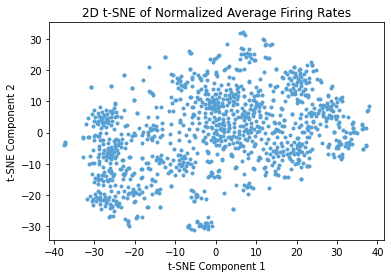

In [51]:
### Pre-process for t-SNE.

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = filtered_normalized_firing_rates.drop(columns=['frame'])
tsne_array = np.array(tsne_df).transpose()

# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=69)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown 117 different Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

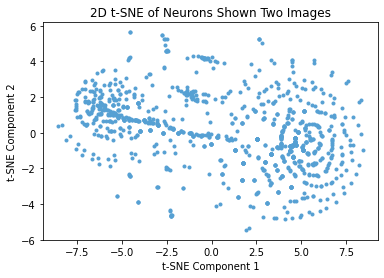

In [60]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]


# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


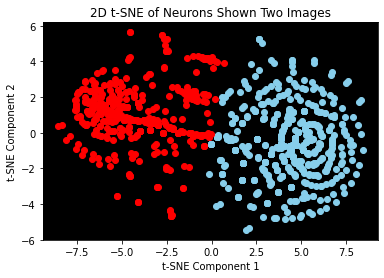

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Define the number of clusters
num_clusters = 2  # Change this to the number of clusters you want

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tsne_2d_results)

# Get the cluster labels
labels = kmeans.labels_

# Define the colors for each cluster
colors = ['skyblue', 'red']  # Change these to the colors you want

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot 2D t-SNE with colors representing different clusters
for i in range(num_clusters):
    plt.scatter(tsne_2d_results[labels == i, 0], tsne_2d_results[labels == i, 1], color=colors[i])

plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.legend()  # Commented out to remove the legend
plt.show()

In [5]:
# Try to plot the unit twice, once for each frame, then color.

### 2.7) Average firing rates of units during each frame, in Hertz and by Z scores.

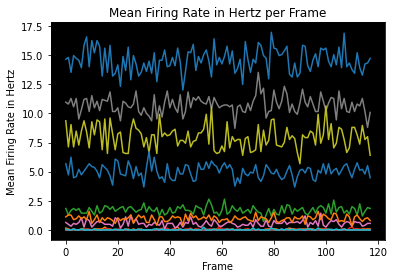

In [71]:
# Choose how many neurons to display.
num_of_neurons_display = 12

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:(num_of_neurons_display+1)].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

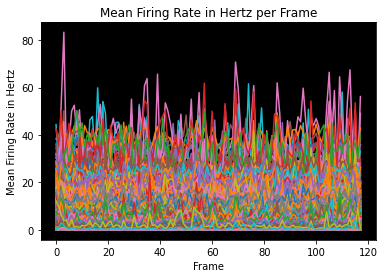

In [84]:
# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

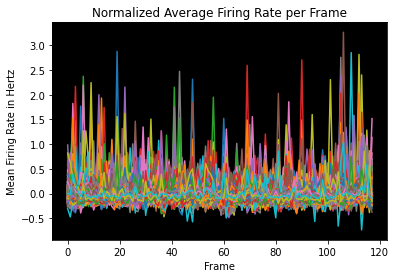

In [89]:
normalized_spikes_per_frame = filtered_normalized_firing_rates.groupby('frame').mean().iloc[1:,1:]
normalized_spikes_per_frame.reset_index(inplace=True)

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
normalized_spikes_per_frame.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Normalized Firing Rate per Frame')

# Show the plot
plt.show()

In [77]:
from sklearn.preprocessing import LabelEncoder

# Create X and y.
y = filtered_normalized_firing_rates['frame'].values
X = filtered_normalized_firing_rates.drop(columns=['frame']).values

# Encode class labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle = False)

num_classes = len(np.unique(y))
input_dim = X_train.shape[-1]


print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([47600, 1141])
y_train shape: torch.Size([47600])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([11900, 1141])
y_test shape: torch.Size([11900])


In [8]:
### 3.10) STGNN Implementation.

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
batch_size = 32

filtered_normalized_firing_rates = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'] != -1]
# Create X and y.
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
y = filtered_normalized_firing_rates['frame'].values

# Encode categorical target values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False)

num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]
num_classes = len(np.unique(y)) - 1

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train_LSTM = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test_LSTM = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Add an extra dimension for features
X_train = X_train_LSTM.unsqueeze(2)
X_test = X_test_LSTM.unsqueeze(2)


# Permute the dimensions to match the expected input shape
X_train = X_train.permute(0, 1, 3, 2)
X_test = X_test.permute(0, 1, 3, 2)

# Fold 4D array into 3D. Necessary for LSTM.
def reshape_data(data):
    B, T, N, F = data.size()
    return data.view(B, T, N * F)
    
X_train_reshaped = reshape_data(X_train).to(device)
X_test_reshaped = reshape_data(X_test).to(device)

# Validation setup
num_samples_val = X_val.shape[0] // seq_len
X_val = X_val[:num_samples_val*seq_len]
X_val = X_val.reshape(num_samples_val, seq_len, num_features)
y_val = y_val[:num_samples_val*seq_len]
y_val = y_val.reshape(num_samples_val, seq_len, 1)
y_val = y_val[:, -1]

# Convert to PyTorch tensors
X_val_LSTM = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Add an extra dimension for features and permute for validation set
X_val = X_val_LSTM.unsqueeze(2)
X_val = X_val.permute(0, 1, 3, 2)
X_val_reshaped = reshape_data(X_val).to(device)

train_loader = DataLoader(list(zip(X_train_reshaped, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test_reshaped, y_test)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_val_reshaped, y_val)), batch_size=batch_size, shuffle=False)

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(" ")
print(f"X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.")
print("X.shape = (B, T, N, F)")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train type: {type(X_train)}")
print(" ")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(" ")
print(f"y_shape = [batch_size, unique_frames_shown_per_{seq_len}_timesteps]")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")
print(" ")
# Define a correlation-based edge index
corr_matrix = np.corrcoef(X, rowvar=False)

# Convert the correlation matrix to an edge index tensor
edge_index = corr_matrix  #find the indices where the correlation matrix is not 0
edge_index = torch.tensor(edge_index.T, dtype=torch.long)  # convert to a PyTorch tensor and transpose
print('Shape of edge_index', np.shape(edge_index))
print('Edge Index',edge_index)

X_val shape: torch.Size([472, 10, 1141, 1])
y_val shape: torch.Size([472, 1])
 
X (array): Matrix of number of batch_size, time_steps_per_frame, num_nodes, and number of features per node.
X.shape = (B, T, N, F)
X_train shape: torch.Size([4248, 10, 1141, 1])
X_test shape: torch.Size([1180, 10, 1141, 1])
X_train type: <class 'torch.Tensor'>
 
X_val shape: torch.Size([472, 10, 1141, 1])
y_val shape: torch.Size([472, 1])
 
y_shape = [batch_size, unique_frames_shown_per_10_timesteps]
y_train shape: torch.Size([4248, 1])
y_test shape: torch.Size([1180, 1])
y_test type: <class 'torch.Tensor'>
 
Shape of edge_index torch.Size([1141, 1141])
Edge Index tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
